In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
FILEPATH_1 = "../data/res1_destructive_test.csv"
FILEPATH_2 = "../data/res2_destructive_test.csv"
FILEPATH_3 = "../data/res3_destructive_test.csv"
df1 = pd.read_csv(FILEPATH_1)
df2 = pd.read_csv(FILEPATH_2)
df3 = pd.read_csv(FILEPATH_3)

In [3]:
def prep_df(df):
    df = df.copy()
    NOMINAL_LOAD_RESISTANCE = 10  # Ohms

    # Remove error values
    mask = (df["Current (mA)"] < 0.0)
    if mask.any():
        idx = mask.idxmax()   # index of first True
        df = df.loc[:idx-1]

    # Add columns
    df["nominal_load_voltage"] = df["Current (mA)"] / 1000 * NOMINAL_LOAD_RESISTANCE  # units: Volts
    df["calc_resistance"] = df["Load voltage (V)"] / df["Current (mA)"] * 1000  # units: Ohms
    df["power"] = df["Load voltage (V)"] * df["Current (mA)"]  # units: mW
    return df

df1_clean = prep_df(df1)
df2_clean = prep_df(df2)
df3_clean = prep_df(df3)

In [4]:
df1_clean

,Time (s),Source voltage (V),Load voltage (V),Curr sense voltage (V),Current (mA),nominal_load_voltage,calc_resistance,power
0,0.027676,-0.014389,1.418169,0.014389,143.889278,1.438893,9.855973,204.059297
1,0.106259,1.433432,1.417917,0.014389,143.889278,1.438893,9.854220,204.022997
2,0.184493,1.433684,1.418295,0.014389,143.889278,1.438893,9.856850,204.077447
3,0.262891,1.433558,1.418169,0.014263,142.627891,1.426279,9.943139,202.270437
4,0.341353,1.433306,1.417917,0.014389,143.889278,1.438893,9.854220,204.022997
...,...,...,...,...,...,...,...,...
323,25.489006,3.528344,3.496683,0.038229,382.291521,3.822915,9.146641,1336.752358
324,25.567567,3.636319,3.611848,0.039617,396.166783,3.961668,9.116988,1430.894178
325,25.646006,3.772296,3.740005,0.040247,402.473721,4.024737,9.292544,1505.253691
326,25.724614,3.814679,3.775954,0.039617,396.166783,3.961668,9.531224,1495.907729


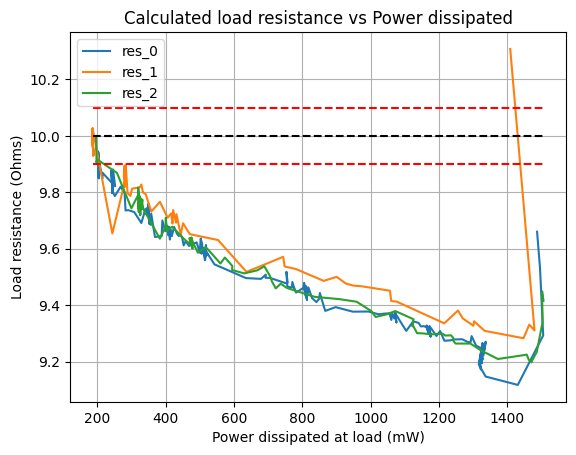

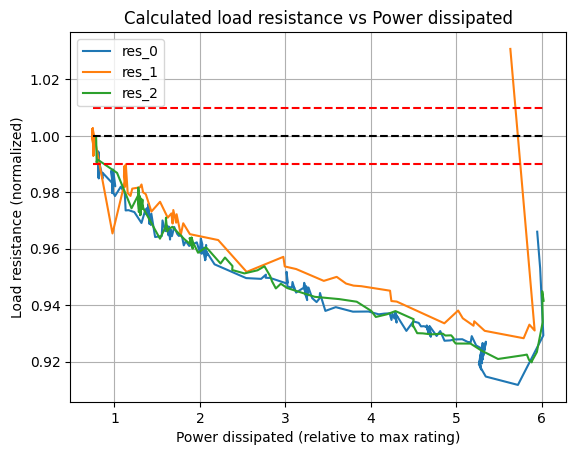

In [5]:
def plot_resistance(dfs, labels=None, x_axis="Current (mA)", 
                    ylabel=None, xlabel=None, title=None, 
                    nominal_resistance=10, tolerance=0.01,
                    normalize_y=False, normalize_x_value=None):
    """
    Plot the calculated resistances from multiple DataFrames on one plot.

    dfs: iterable of pandas DataFrames
    labels: optional iterable of legend labels
    x_axis: str specifying column to plot on x-axis
    ylabel: str to label y-axis on plot
    xlabel: str to label x-axis on plot
    title: str to use as plot title
    normalize_y: bool to indicate whether resistance values should be normalized
    normalize_x_value: float to normalize x-axis values, disabled if None
    """
    # Input validation
    if labels is None:
        labels = [f"res_{i}" for i in range(len(dfs))]
    else:
        if len(labels) != len(dfs):
            raise Exception("Input 'labels' must be same length as 'dfs'")

    if not isinstance(xlabel, str):
        raise Exception("Input 'xlabel' must be of type str")

    if not isinstance(ylabel, str):
        raise Exception("Input 'ylabel' must be of type str")

    if not isinstance(title, str):
        raise Exception("Input 'title' must be of type str")

    if not isinstance(nominal_resistance, int) and not isinstance(nominal_resistance, float):
        raise Exception("Input 'nominal_resistance' must be of type int or float")

    if not isinstance(tolerance, float) or tolerance < 0.0 or tolerance > 1.0:
        raise Exception("Input 'tolerance' must be a float between 0.0 and 1.0")

    if not isinstance(normalize_y, bool):
            raise Exception("Input 'normalize_y' must be either True or False")
            
    if normalize_x_value is not None:
        if not isinstance(normalize_x_value, float) and not isinstance(normalize_x_value, int):
            raise Exception("Input 'normalize_x_value' must be int or float")

    #dfs = list(dfs)
    #n_traces = len(dfs)
    NOMINAL_LOAD_RESISTANCE = float(nominal_resistance) 

    # Plot data
    fig, ax = plt.subplots()
    x_min = 999
    x_max = 0
    for df, label in zip(dfs, labels):
        df = df.copy()
        if normalize_y:
            df["calc_resistance"] = df["calc_resistance"] / NOMINAL_LOAD_RESISTANCE
        if normalize_x_value is not None:
            df[x_axis] = df[x_axis] / normalize_x_value
        x_min = min(x_min, min(df[x_axis]))
        x_max = max(x_max, max(df[x_axis]))
        ax.plot(df[x_axis], df["calc_resistance"], label=str(label))

    # Normalize nominal values and labels, if enabled
    nominal_value = 1.0 if normalize_y else NOMINAL_LOAD_RESISTANCE
    
    if ylabel is None:
        ylabel = "Resistance (Ohms)" if normalize_y else "Resistance (normalized)"
    if xlabel is None:
        xlabel = f"{x_axis} (normalized)" if normalize_x_value is not None else x_axis

    # Plot nominal and tolerance values
    ones_line = np.ones(2)
    nominal_value = 1.0 if normalize_y else NOMINAL_LOAD_RESISTANCE
    ax.plot([x_min, x_max], nominal_value * ones_line, 'k--')
    ax.plot([x_min, x_max], nominal_value * (1-tolerance) * ones_line, 'r--')
    ax.plot([x_min, x_max], nominal_value * (1+tolerance) * ones_line, 'r--')
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid()
    ax.legend()
    if title is not None:
        ax.set_title(title)
    plt.show()

dfs = [df1_clean, df2_clean, df3_clean]

# Non-normalized plot
plot_resistance(dfs, 
                x_axis="power", 
                ylabel="Load resistance (Ohms)",
                xlabel="Power dissipated at load (mW)",
                title="Calculated load resistance vs Power dissipated", 
                normalize_y=False, normalize_x_value=None)

# Normalized plot
plot_resistance(dfs, 
                x_axis="power", 
                ylabel="Load resistance (normalized)",
                xlabel="Power dissipated (relative to max rating)",
                title="Calculated load resistance vs Power dissipated", 
                normalize_y=True, normalize_x_value=250)